<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries and data importing

In [1]:
# update sklearn package to v0.24.x which is the latest version
!pip install --upgrade scikit-learn
# install shap library to draw fancy model explainations
!pip install shap
# install skmultilearn for multi-label classification
!pip install scikit-multilearn

     |████████████████████████████████| 22.3MB 127kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 358kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=ddbbf8fc8d203b95f0b92b78f7c2680130da3e0ed3c0cad1822e0e2d587ba634
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 92kB 3.8MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [3]:
# dataset = pd.read_csv("/content/canine_chemical_dataset_v1.6.csv")
dataset = pd.read_csv("/content/checkpoint.csv")
print(dataset.head())

features = dataset.iloc[:, :30]
labels = dataset.iloc[:, 30:]

              Species   Age  ... Volume depletion  hepatocellular injury
0       HERDING GROUP  10.0  ...                0                      0
1  NON-SPORTING GROUP  13.0  ...                0                      0
2       WORKING GROUP   1.0  ...                0                      0
3       HERDING GROUP   6.0  ...                0                      0
4       HERDING GROUP   3.0  ...                0                      0

[5 rows x 244 columns]


## EDA: feature correlation detection

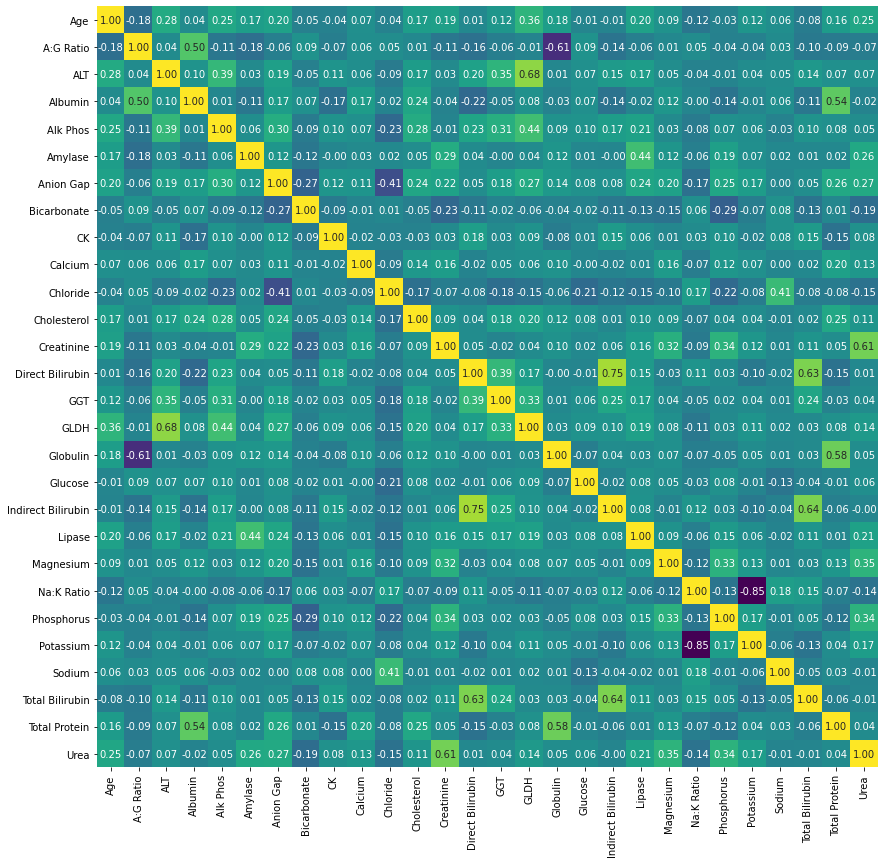

In [ ]:
corr_mat = features.corr()
fig = plt.figure(figsize=(14, 14))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, 
            cmap='viridis', annot=True, fmt='.2f', cbar=False)

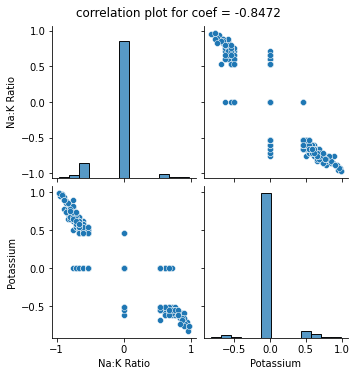

In [ ]:
for r_idx, row in enumerate(corr_mat.values):
    for c_idx, e in enumerate(row[r_idx+1:]):
        if ((e >= 0.8) | (e <= -0.8)) & (r_idx != c_idx):
            plt.rcParams['figure.figsize'] = (5,5)
            sub_df = features[[features.columns[r_idx+2], features.columns[c_idx+r_idx+3]]]
            cp = sns.pairplot(sub_df)
            cp.fig.suptitle("correlation plot for coef = %.4f" % e, y=1.03)
            plt.show()

according to the correlation map, we have some features which have high level of correlations. We must perform feature engineering (dim. reduction using PCA or creating new feature based on correlated ones) on some of the input features

## EDA: label correlation detection and reduction strategies

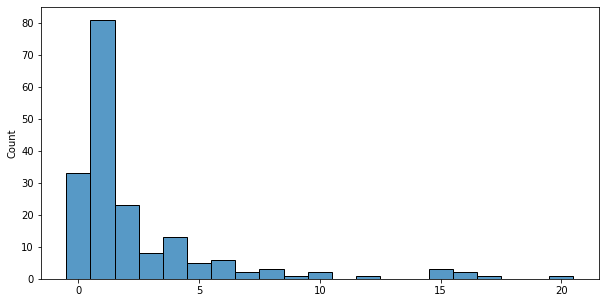

In [4]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs.append(np.sum(column))

fig = plt.figure(figsize=(10, 5))
sns.histplot(label_freqs, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

which threshold? we can omit labels with freq < 5 (then change later to see differences). on average, each label is happen 26.5 times.

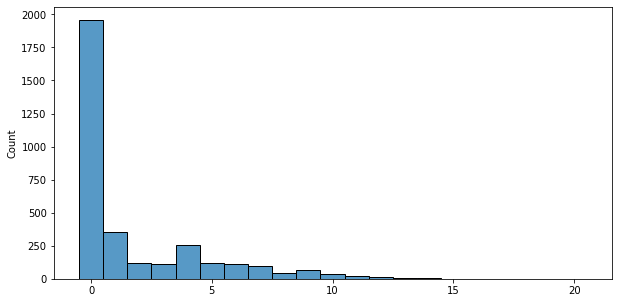

In [5]:
# having labels that never happen (freq = 0) is weird. Let's see how many labels are
# activated for each record
num_activated_labels = list()
for row_idx, row in labels.iterrows():
    num_activated_labels.append(np.sum(row))

fig = plt.figure(figsize=(10, 5))
sns.histplot(num_activated_labels, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

we can see that many records have no activated labels! on average, each record has 1.78 activated labels. Since records with no activated labels mean the canine breed is healthy, we certainly keep these records.
actually, since we have 1958 healthy records out of 3329 samples, we can do a binary disease detection at first and perform disease classification on unhealthy predictions. (hierarchical classification) 

In [ ]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 2: # omit labels with less than 2 occurances
        drop_list.append(label)

labels = labels.drop(columns=drop_list)
print('number of labels is reduced from %d to %d' % (len(label_names), len(labels.values[0])))

number of labels is reduced from 214 to 100


## model development

In [6]:
# construct feature transformation pipeline
ct = ColumnTransformer(
    [('onehot_encoder', OneHotEncoder(drop='first', sparse=False), [0, 2]),
     ('minmax_scaler', MinMaxScaler((0, 1)), [1])], # scale 'age' to [0,1]
    remainder='passthrough') # leave other columns untouched
features_encoded = ct.fit_transform(X=features)

### hierarchical classification

In [9]:
# create new label: sick or not? (for binary classification)
is_sick = np.array([1.0 if np.sum(row) >= 1 else 0.0 for row in labels.values])
print('num pos values:', np.sum(is_sick))
print('num neg values:', len(is_sick) - np.sum(is_sick))

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(is_sick), 
                                                  y=is_sick)
class_weights = dict({0: class_weights[0], 1: class_weights[1]})
pos_ratio = np.sum(is_sick) / (len(is_sick)-np.sum(is_sick))

num pos values: 1371.0
num neg values: 1958.0


In [25]:
# # feature engineering: avg value of blood-tests (values within normal ranges are set to 0)
# features_encoded[:,11:] = np.array([np.where(e<0, np.abs(e), e) for e in features_encoded[:,11:]])
# avg_val = np.array([np.sum(e)/28 for e in features_encoded[:, 11:]]).reshape(-1, 1)

# # feature engineering: avg number of zeros (values within normal ranges are set to 0)
# avg_zeros = np.array([(e.size - np.count_nonzero(e))/28 for e in features_encoded[:, 11:]]).reshape(-1, 1)

In [18]:
# perform K-Fold cross-validation and find model scores on training/validation data
def get_results_of(model):
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
    results = cross_validate(estimator=model, X=features_encoded, y=is_sick, cv=cv, 
                             scoring=['accuracy', 'roc_auc'])
    acc_scores = results['test_accuracy']
    print('mean ACC is %.3f (std=%.3f) / best ACC is %.3f' 
            % (abs(np.mean(acc_scores)), np.std(acc_scores), abs(np.max(acc_scores))))
    auc_scores = results['test_roc_auc']
    print('mean ROC AUC is %.3f (std=%.3f) / best ROC AUC is %.3f' 
            % (abs(np.mean(auc_scores)), np.std(auc_scores), abs(np.max(auc_scores))))

In [ ]:
from sklearn.svm import SVC
params = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [0.1, 1, 10], 
          'degree': [1, 2, 3, 4]}
base_clf = SVC(class_weight=class_weights)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for SVM Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}
base_clf = DecisionTreeClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for DecisionTree Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.linear_model import LogisticRegression
params = {'C': [0.1, 1.0, 2.0, 10.0], 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
base_clf = LogisticRegression(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for LogReg Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


from sklearn.ensemble import RandomForestClassifier
params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'],
          'n_estimators': [20, 50, 100, 200]}
base_clf = RandomForestClassifier(class_weight=class_weights)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for RF Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)
print('-----------------------------------------------------')


import xgboost as xgb
params = {'max_depth': [2, 3, 4, 5], 'n_estimators': [20, 50, 100, 200]}
base_clf = xgb.XGBClassifier(scale_pos_weight=1/pos_ratio)
clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
clfs.fit(features_encoded, is_sick)
print('best observed parameters for XGB Clf:', clfs.best_params_)
get_results_of(model=clfs.best_estimator_)

best observed parameters for SVM Clf: {'C': 0.1, 'degree': 4, 'kernel': 'poly'}
mean cross-validation ACC is 0.599 (std=0.015) / best cross-validation ACC is 0.637
mean cross-validation ROC AUC is 0.601 (std=0.025) / best cross-validation ROC AUC is 0.653
-----------------------------------------------------
best observed parameters for DecisionTree Clf: {'criterion': 'gini', 'max_depth': 2}
mean cross-validation ACC is 0.593 (std=0.020) / best cross-validation ACC is 0.622
mean cross-validation ROC AUC is 0.616 (std=0.024) / best cross-validation ROC AUC is 0.645
-----------------------------------------------------
best observed parameters for LogReg Clf: {'C': 0.1, 'solver': 'newton-cg'}
mean cross-validation ACC is 0.589 (std=0.020) / best cross-validation ACC is 0.625
mean cross-validation ROC AUC is 0.614 (std=0.025) / best cross-validation ROC AUC is 0.651
-----------------------------------------------------
best observed parameters for RF Clf: {'criterion': 'gini', 'max_depth'

best model in terms of average ACC as well as AUC is (as expected) the **XGBoost classifier**

### flat classification of multi-label data

In [ ]:
# def calculate_class_weights(y_true):
#     from sklearn.utils.class_weight import compute_class_weight
#     number_dim = np.shape(y_true)[1]
#     weights = np.empty([number_dim, 2])
#     for i in range(number_dim):
#         weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
#     return weights

# def get_weighted_loss(weights):
#     def weighted_loss(y_true, y_pred):
#         return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
#     return weighted_loss

In [7]:
# define multilabel classification metrics
def micro_avg_f1_score(y, yhat):
    return sklearn.metrics.f1_score(y, yhat, average='micro')

def alpha_evaluation_score(y, yhat):
    alpha = 1.0; beta = 1.0; gamma = 0.8 # FN is more important than FP, so beta > gamma
    # compute true positives across training examples and labels
    tp = np.sum(np.logical_and(y, yhat))
    # compute false negatives (Missed Labels) across training examples and labels
    fn = np.sum(np.logical_and(y, np.logical_not(yhat)))
    # compute False Positive across training examples and labels.
    fp = np.sum(np.logical_and(np.logical_not(y), yhat))
    # Compute alpha evaluation score
    alpha_score = (1 - ((beta*fn + gamma*fp) / (tp + fn + fp + 0.00001)))**alpha
    return alpha_score


metrics = {'micro_f1': sklearn.metrics.make_scorer(micro_avg_f1_score),
           'alpha_eval': sklearn.metrics.make_scorer(alpha_evaluation_score)}

In [ ]:
# # perform K-Fold cross-validation and find model scores on training/validation data
# def get_results_of(model):
#     cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
#     results = cross_validate(estimator=model, X=features_encoded, y=labels.values, cv=cv, 
#                              scoring=metrics)
#     # print(results)
#     f1_scores = results['test_micro_f1']
#     print('mean micro average f1 is %.3f (std=%.3f) / best micro average f1 is %.3f' 
#             % (abs(np.mean(f1_scores)), np.std(f1_scores), abs(np.max(f1_scores))))
#     alpha_scores = results['test_alpha_eval']
#     print('mean alpha is %.3f (std=%.3f) / best alpha is %.3f' 
#             % (abs(np.mean(alpha_scores)), np.std(alpha_scores), abs(np.max(alpha_scores))))

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
# from skmultilearn.adapt import MLkNN
# from scipy.sparse import csr_matrix, lil_matrix


clf = RandomForestClassifier(class_weight='balanced', random_state=0)
# clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=0))
# clf = BinaryRelevance(RandomForestClassifier(class_weight='balanced', random_state=0))
# clf = ClassifierChain(RandomForestClassifier(class_weight='balanced', random_state=0))
# clf = LabelPowerset(RandomForestClassifier(class_weight='balanced', random_state=0))


X_train, X_test, y_train, y_test = train_test_split(features_encoded, labels.values, 
                                                    test_size=0.1, random_state=0)

f = list()
a = list()
for idx, col_name in enumerate(labels.columns):
    # print('classifying %s label:' % col_name)
    clf.fit(X_train, y_train[:, idx]) # if needed: idx:idx+1
    preds = clf.predict(X_test)
    # print('alpha:', alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    # print('f1:', micro_avg_f1_score(y=y_test[:, idx], yhat=preds))
    a.append(alpha_evaluation_score(y=y_test[:, idx], yhat=preds))
    f.append(micro_avg_f1_score(y=y_test[:, idx], yhat=preds))


clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print('F1:', micro_avg_f1_score(y=y_test, yhat=preds))
print('alpha:', alpha_evaluation_score(y=y_test, yhat=preds))

F1: 0.15089514066496165
alpha: 0.10954358078086335


In [ ]:
print(np.mean(f))
print(np.mean(a))

0.9808708708708709
0.5315303964374067


In [ ]:
idx = np.random.randint(0, len(y_test))
# idx = 246
print(idx)
print(y_test[idx])
print(preds[idx])

print('F1:', micro_avg_f1_score(y=y_test[idx], yhat=preds[idx]))
print('alpha:', alpha_evaluation_score(y=y_test[idx], yhat=preds[idx]))

In [ ]:
f1_scores = list()
alpha_scores = list()

for idx in range(0, len(y_test)):
    f1_scores.append(micro_avg_f1_score(y=y_test[idx], yhat=preds[idx]))
    alpha_scores.append(alpha_evaluation_score(y=y_test[idx], yhat=preds[idx]))

ValueError: ignored

In [ ]:
print(np.mean(f1_scores))
print(np.mean(alpha_scores))

0.8225825825825824
0.22577995101990642


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

matrices = multilabel_confusion_matrix(y_test, preds)

In [ ]:
print(matrices)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# params = {'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}
# cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=17)
# base_clf = DecisionTreeClassifier()

# clfs = GridSearchCV(estimator=base_clf, param_grid=params, cv=cv)
# clfs.fit(features_encoded, labels.values)
# print('best observed parameters for DecisionTree Clf:', clfs.best_params_)
# get_results_of(model=clfs.best_estimator_)

## final model with result visualization

In [ ]:
from sklearn.metrics import confusion_matrix
clf = xgb.XGBClassifier(max_depth=2, scale_pos_weight=1/pos_ratio)

X_train, X_test, y_train, y_test = train_test_split(features_encoded, is_sick, test_size=0.2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

[[1017  551]
 [ 313  782]]
[[228 162]
 [ 84 192]]


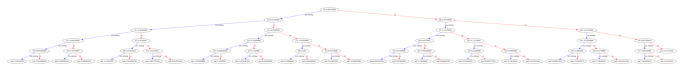

In [ ]:
xgb.plot_tree(booster=clfs.best_estimator_, num_trees=0)
plt.rcParams['figure.figsize'] = [12, 6]
plt.show()

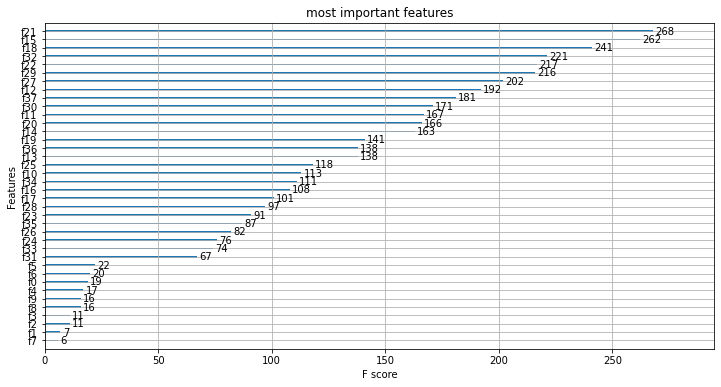

In [ ]:
xgb.plot_importance(booster=clfs.best_estimator_)
plt.rcParams['figure.figsize'] = [12, 6]
plt.title('most important features')
plt.show()

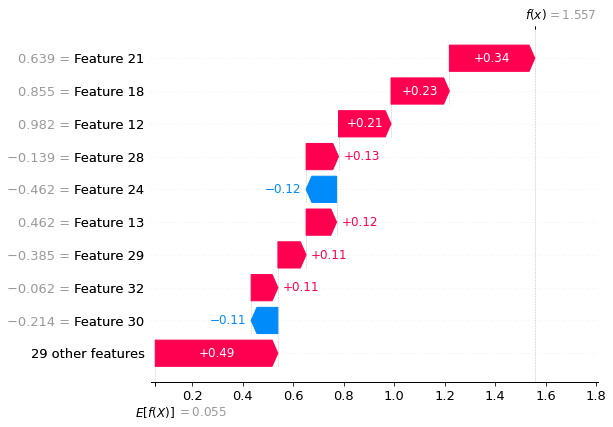

In [ ]:
import shap
explainer = shap.Explainer(model=clf)
shap_values = explainer(X=features_encoded, y=is_sick)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

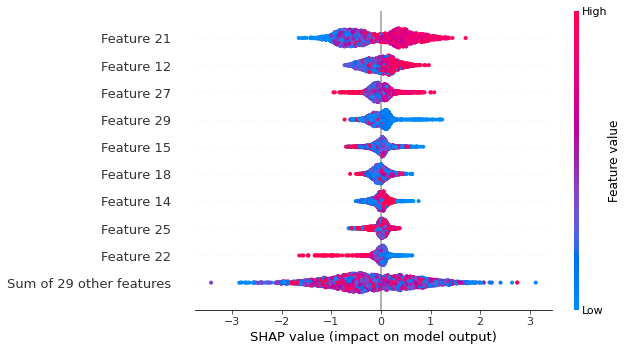

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

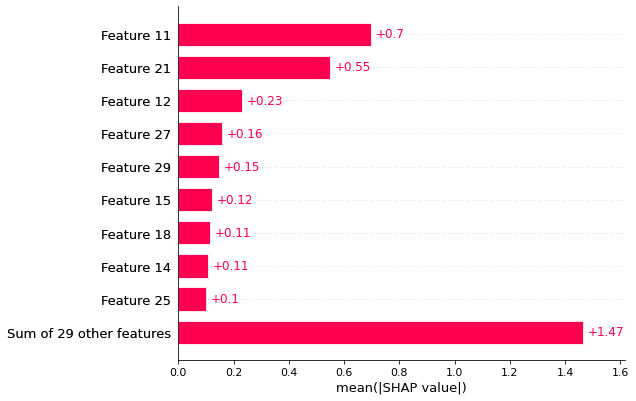

In [ ]:
shap.plots.bar(shap_values)